In [1]:
%matplotlib inline
%run //anaconda/lib/python2.7/chen_import.py
%run //anaconda/lib/python2.7/chen_pdf_analysis.py
%run //anaconda/lib/python2.7/chen_general_plotting.py



//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from skimage import morphology
#import wcsaxes
from sklearn.linear_model import LinearRegression
from astrodendro import pruning, pp_catalog, ppv_catalog

from scimes import SpectralCloudstering
from itertools import cycle
from radfil import radfil_class

from fil_finder import fil_finder_2D
from scipy.interpolate import splprep
from scipy.interpolate import splev

from scipy import ndimage as ndi

from skimage import morphology


____
# Data

In [4]:
# cut, wrap, shift, bins
setups = ['oooo', 'ooox', 'ooxo', 'ooxx',\
          'oxoo', 'oxox', 'oxxo', 'oxxx',\
          'xoxo', 'xoxx']

d_data = {}
## Load data
### PerB5
direcData = '/Users/hopechen/Documents/projects/Per/data/Herschel/Perseus_east/'
hduData = fits.open(direcData+'Per_east_colden_masked.fits')[0]
data, header = hduData.data, hduData.header
xL, xR = 100, 250
yL, yR = 700, 850
densThres = 2.4*9.4e20 # A_V = 2.4
dendro = Dendrogram.compute(data[yL:yR, xL:xR], min_value = densThres, min_delta = densThres*3., min_npix = 500)
header['CRPIX1'] = header['CRPIX1'] - xL
header['CRPIX2'] = header['CRPIX2'] - yL
header['NAXIS1'] = (xR-xL)
header['NAXIS2'] = (yR-yL)
d_data['PerB5'] = {'image': dendro.data, 'mask': dendro[0].get_mask(), 'header': header}

### Musca
direcData = '/Users/hopechen/Documents/projects/git_projects/radfil/Tutorial_Data/'
hduData = fits.open(direcData+'HGBS_musca_column_density_map.fits')[0]
data, header = hduData.data, hduData.header
mask = fits.open(direcData+'Musca_mask.fits')[0].data.astype(bool)
d_data['Musca'] = {'image': data, 'mask': mask, 'header': header}
    
### ENZO
direcData = '/Users/hopechen/Documents/projects/PDF/simulation/Blakesley_nazare/Mid_512/'
hduData = fits.open(direcData+'Mid_512_0050_Density_cube.fits')[0]
data = np.sum(hduData.data, axis = 0)[0:256, 0:256]
mask = Dendrogram.compute(data, min_value = 1000., min_delta = 1e4, min_npix = 2000)[0].get_mask()
mask = morphology.binary_closing(mask)
d_data['ENZO'] = {'image': data, 'mask': mask, 'header': None}

In [5]:
d_distance = {'PerB5': 260., 'Musca': 200., 'ENZO': None}
d_beamwidths = {'PerB5': 42., 'Musca': 36.3, 'ENZO': 1.}
d_samp_ints = {'PerB5': 3, 'Musca': 20, 'ENZO': 1}

____
# Tests

PerB5 ====
oooo ...
==== Gaussian ====
amplitude: 1.384E+21
width: 0.091
==== Plummer-like ====
amplitude: 1.580E+21
p: 2.529
R_flat: 0.066
ooox ...
No binning is applied.
==== Gaussian ====
amplitude: 2.764E+21
width: 0.084
==== Plummer-like ====
amplitude: 2.995E+21
p: 2.711
R_flat: 0.073
ooxo ...
==== Gaussian ====
amplitude: 1.203E+21
width: 0.107
==== Plummer-like ====
amplitude: 1.209E+21
p: 6.849
R_flat: 0.239
ooxx ...
No binning is applied.


==== Gaussian ====
amplitude: 2.580E+21
width: 0.089
==== Plummer-like ====
amplitude: 2.580E+21
p: 10340.650
R_flat: 9.074
oxoo ...
==== Gaussian ====


amplitude: 1.134E+21
width: 0.076
==== Plummer-like ====
amplitude: 1.134E+21
p: 762.983
R_flat: 2.094
oxox ...
No binning is applied.
==== Gaussian ====
amplitude: 2.446E+21
width: 0.070
==== Plummer-like ====
amplitude: 2.583E+21
p: 4.102
R_flat: 0.096
oxxo ...
==== Gaussian ====


amplitude: 1.247E+21
width: 0.109
==== Plummer-like ====
amplitude: 1.247E+21
p: 35524.217
R_flat: 20.467
oxxx ...
No binning is applied.
==== Gaussian ====
amplitude: 2.554E+21
width: 0.088
==== Plummer-like ====
amplitude: 2.555E+21
p: 11308.434
R_flat: 9.392
xoxo ...
==== Gaussian ====
amplitude: 1.412E+21
width: 0.092
==== Plummer-like ====
amplitude: 1.508E+21
p: 2.840
R_flat: 0.089
xoxx

samp_int is not used. cut is False.
shift and/or wrap are not used. cut is False.
samp_int is not used. cut is False.


 ...
No binning is applied.
==== Gaussian ====
amplitude: 2.754E+21
width: 0.083
==== Plummer-like ====
amplitude: 2.789E+21
p: 6.978
R_flat: 0.187


shift and/or wrap are not used. cut is False.


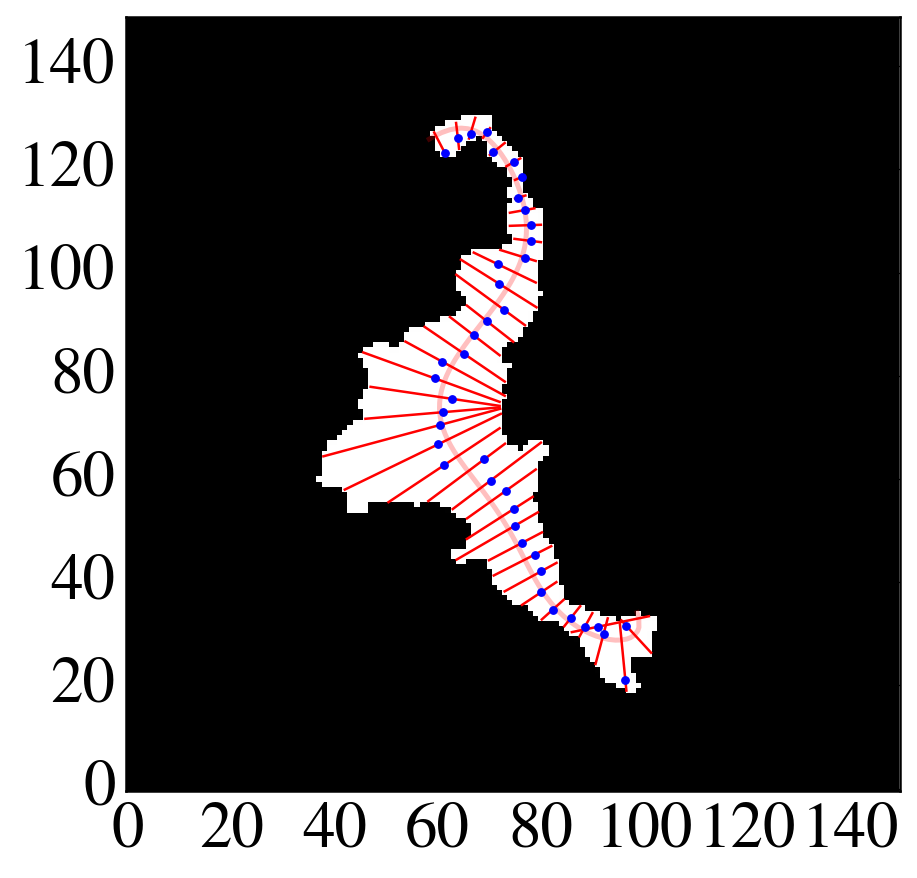

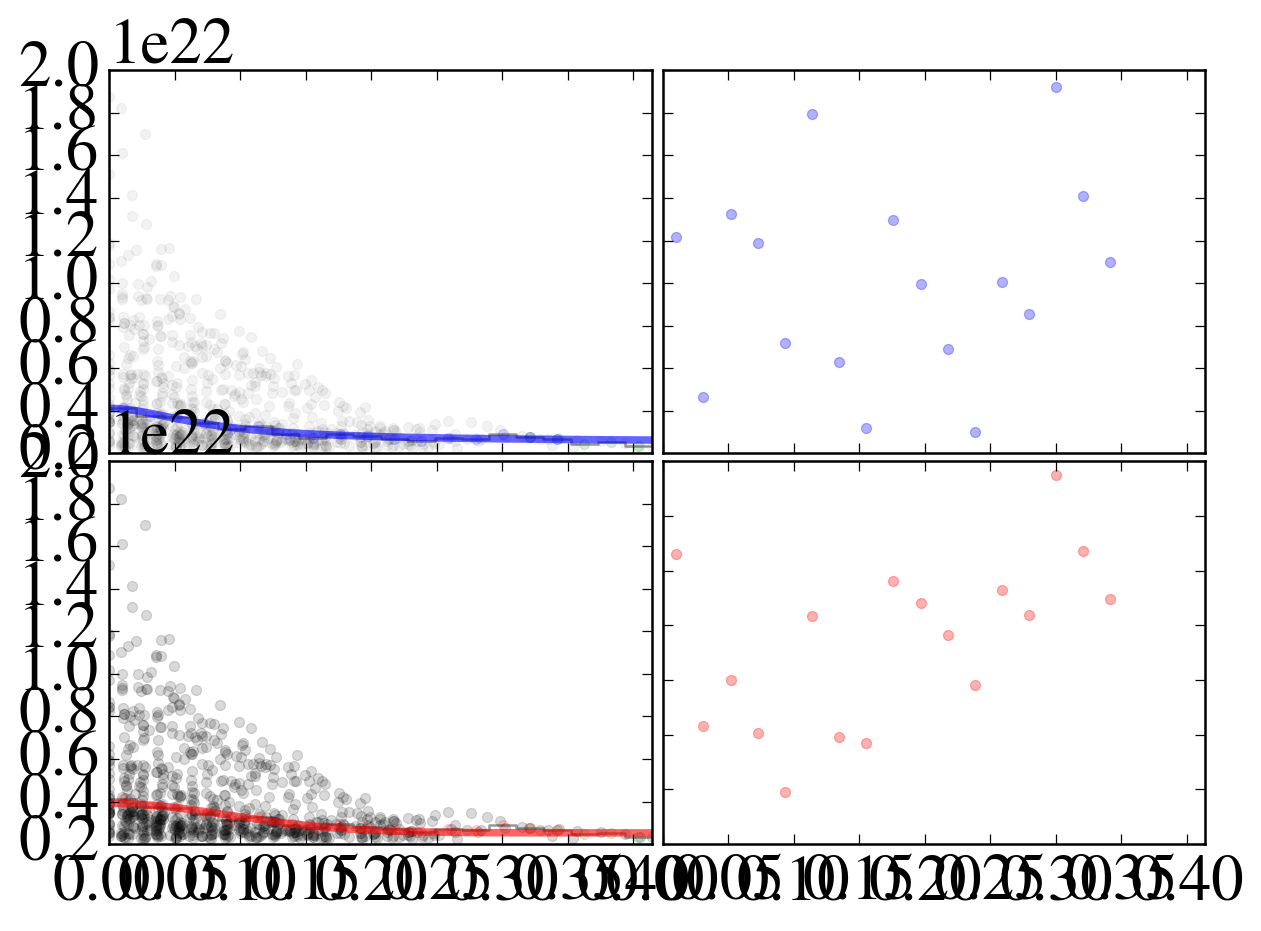

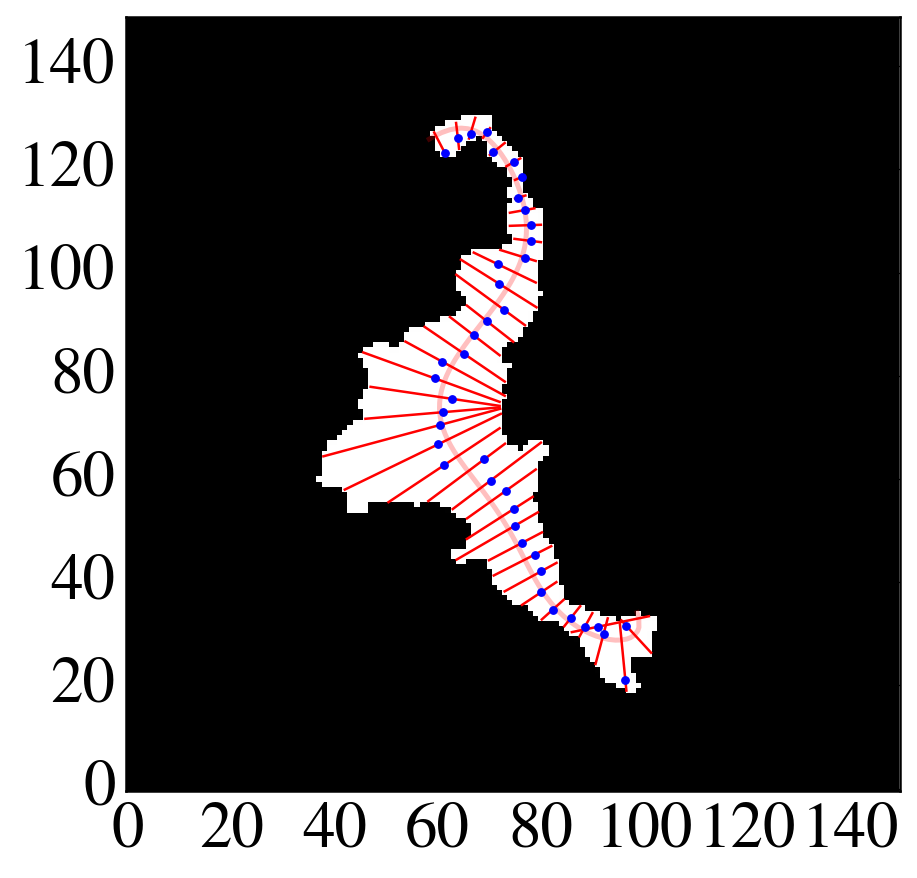

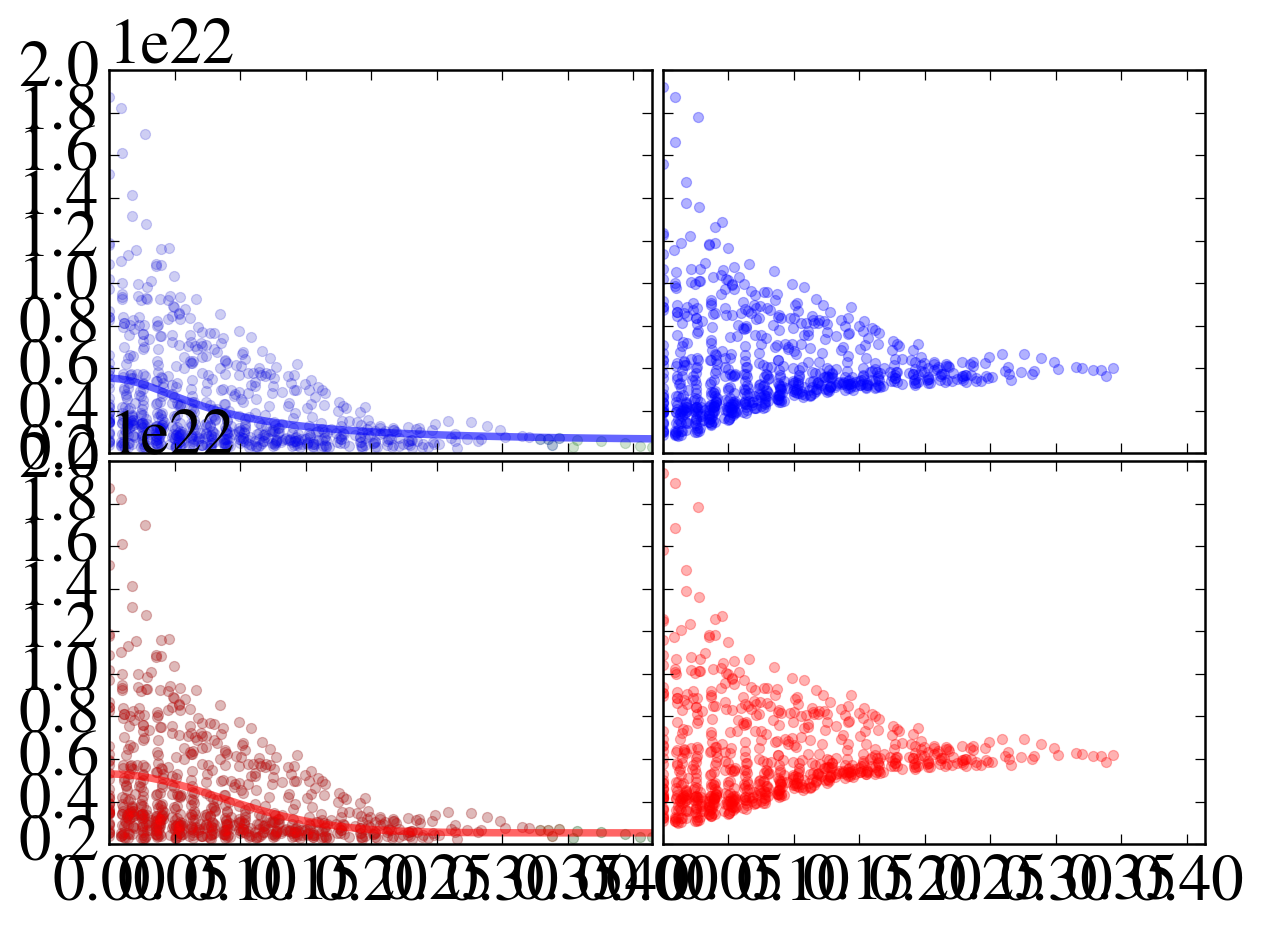

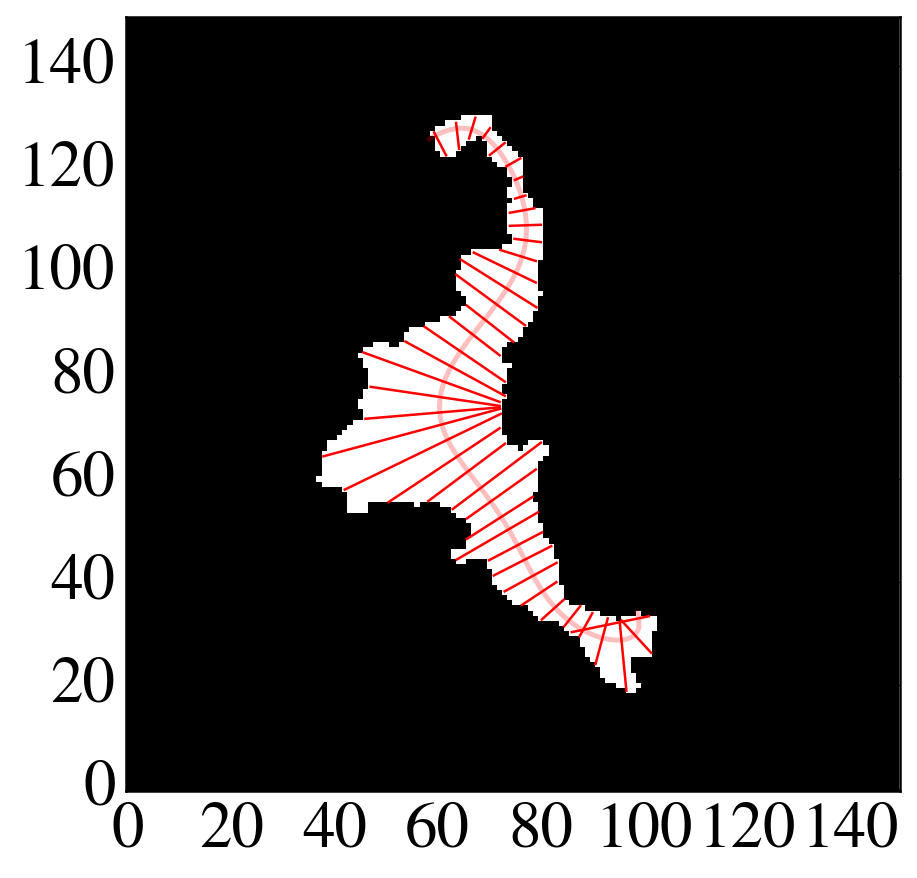

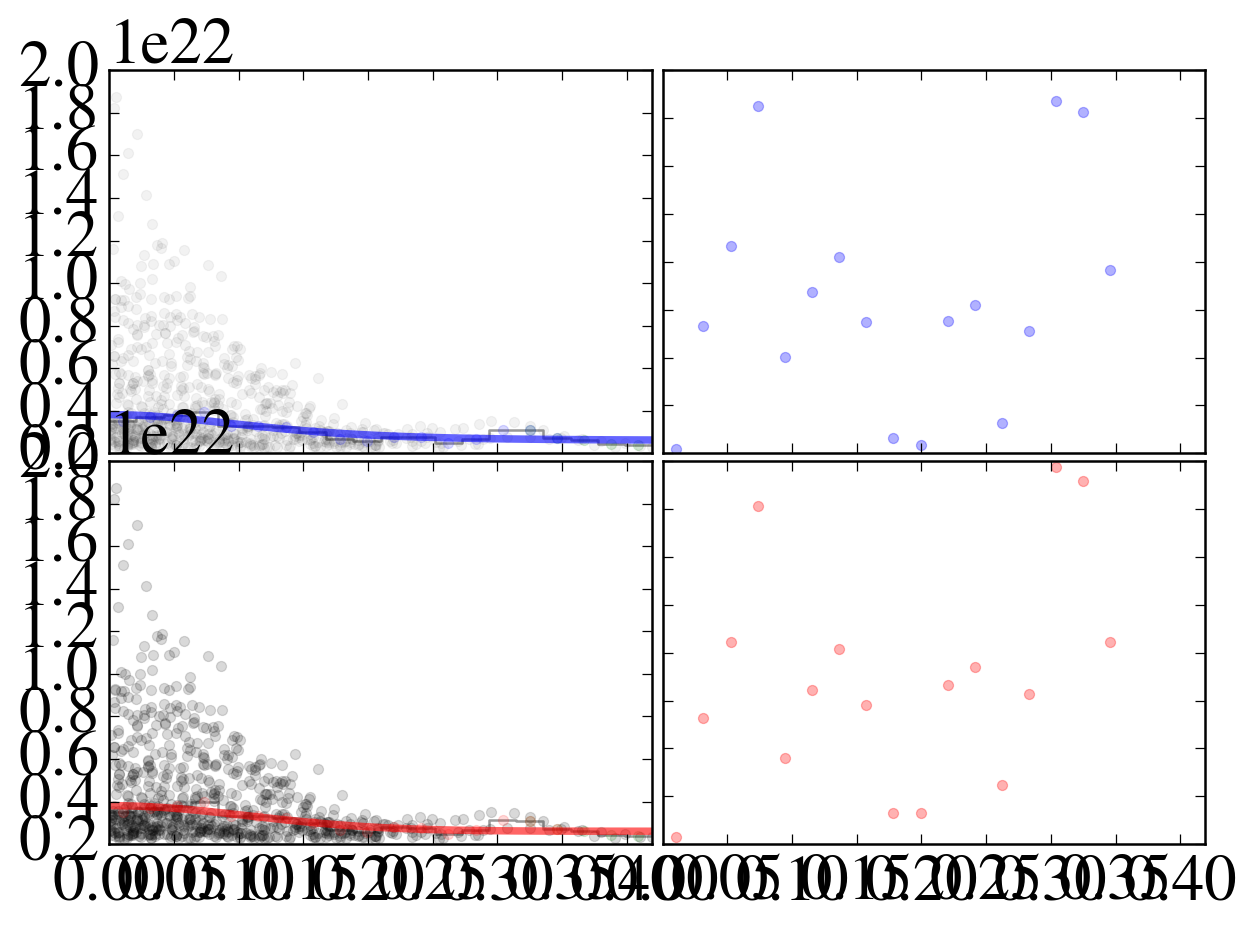

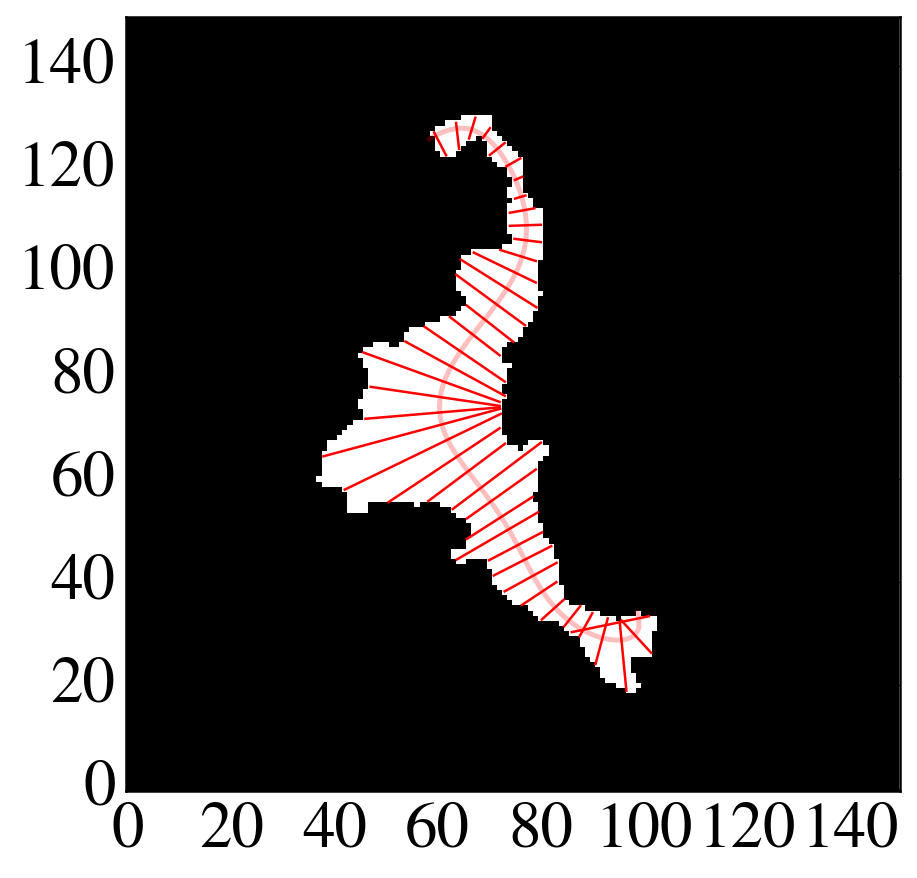

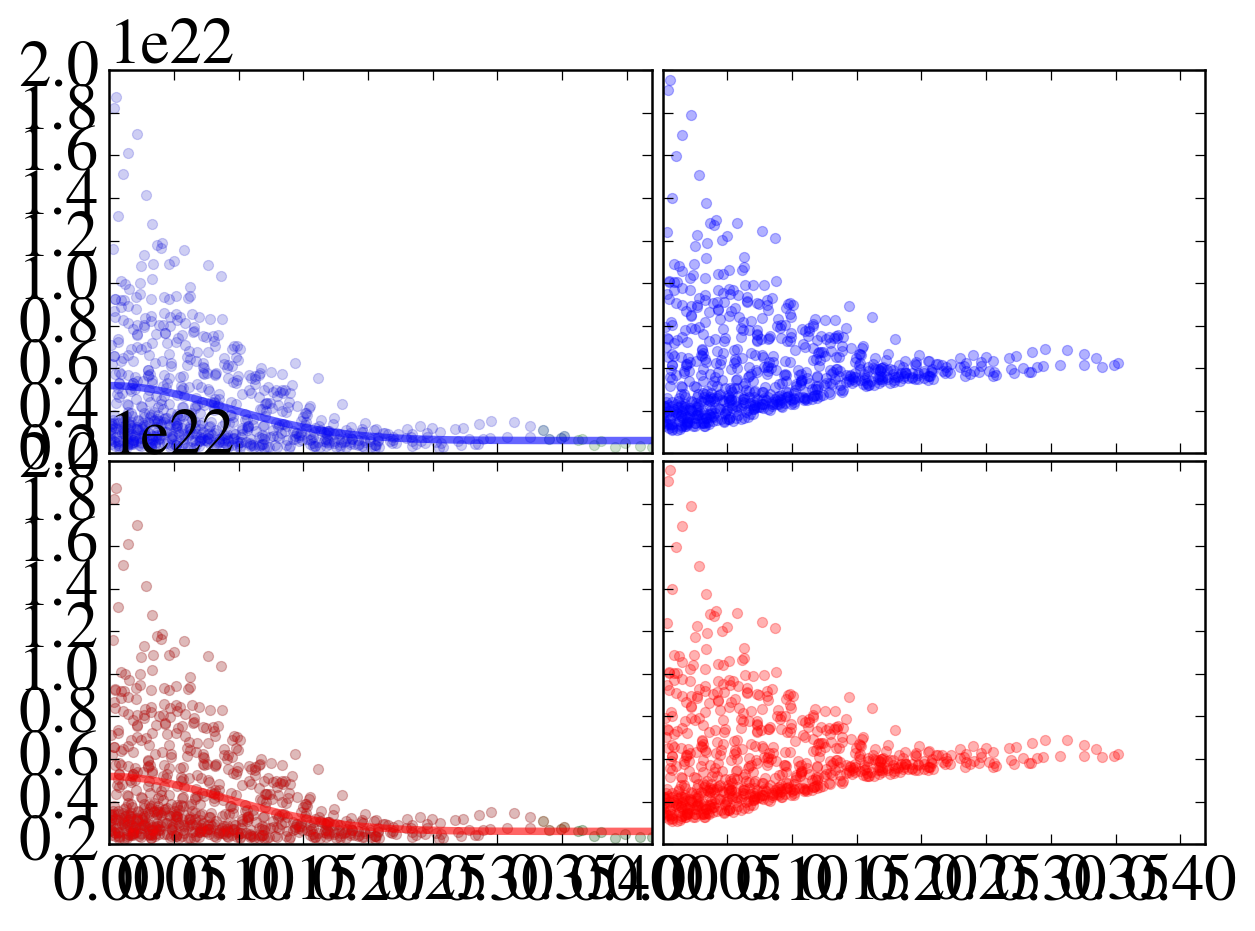

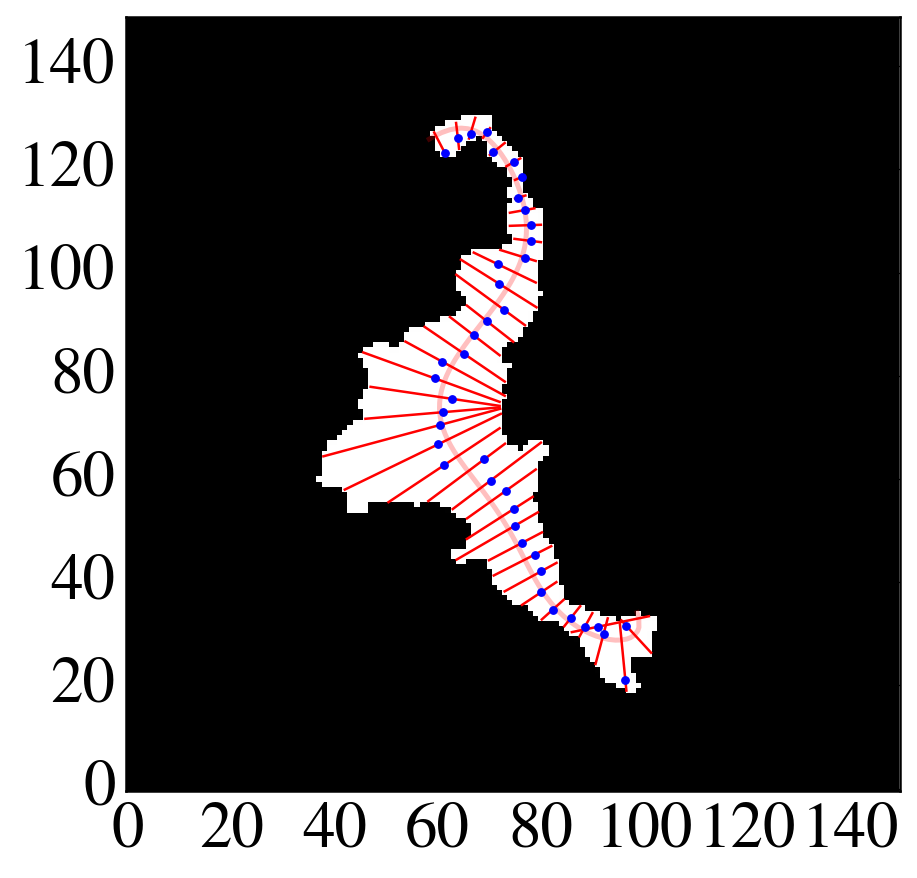

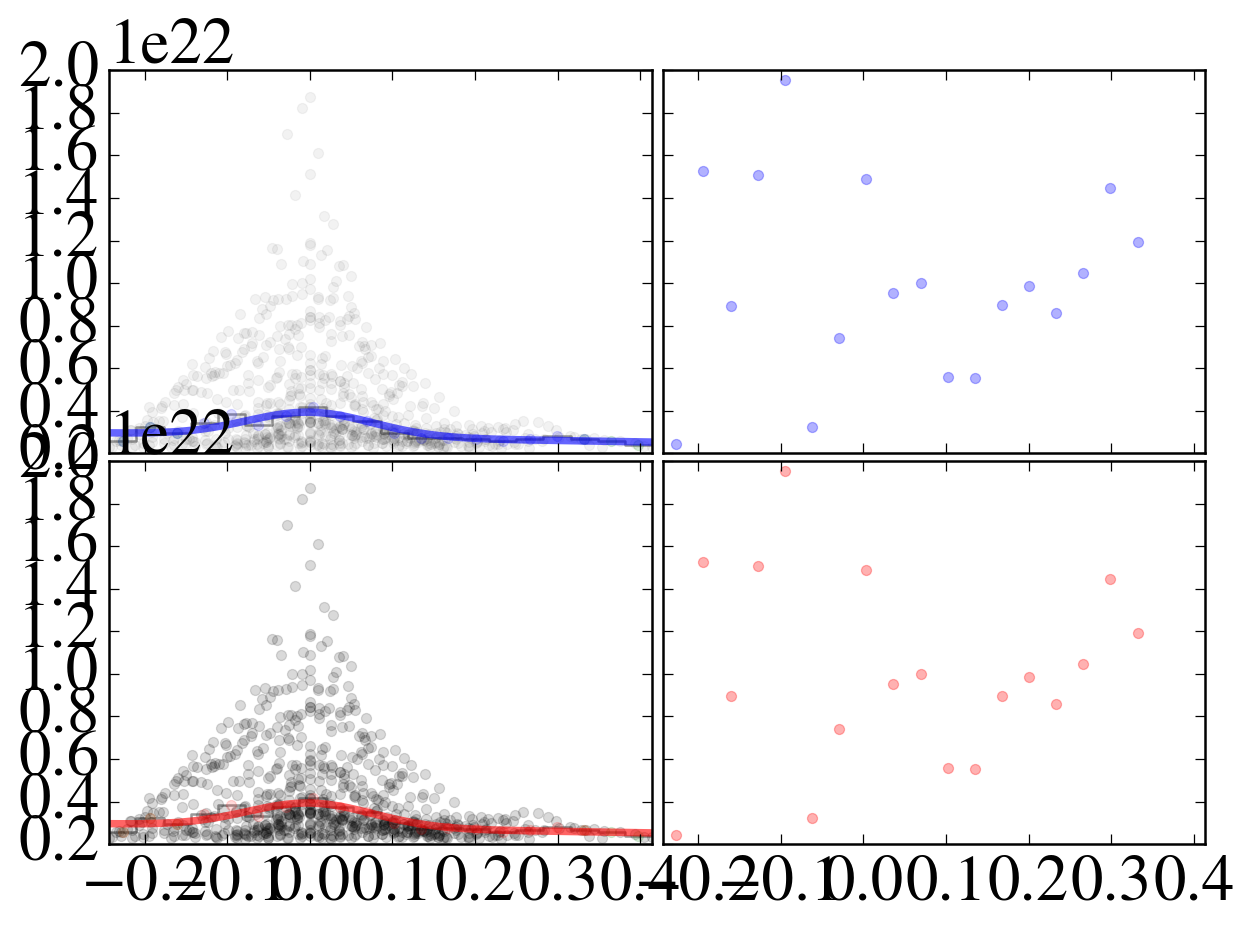

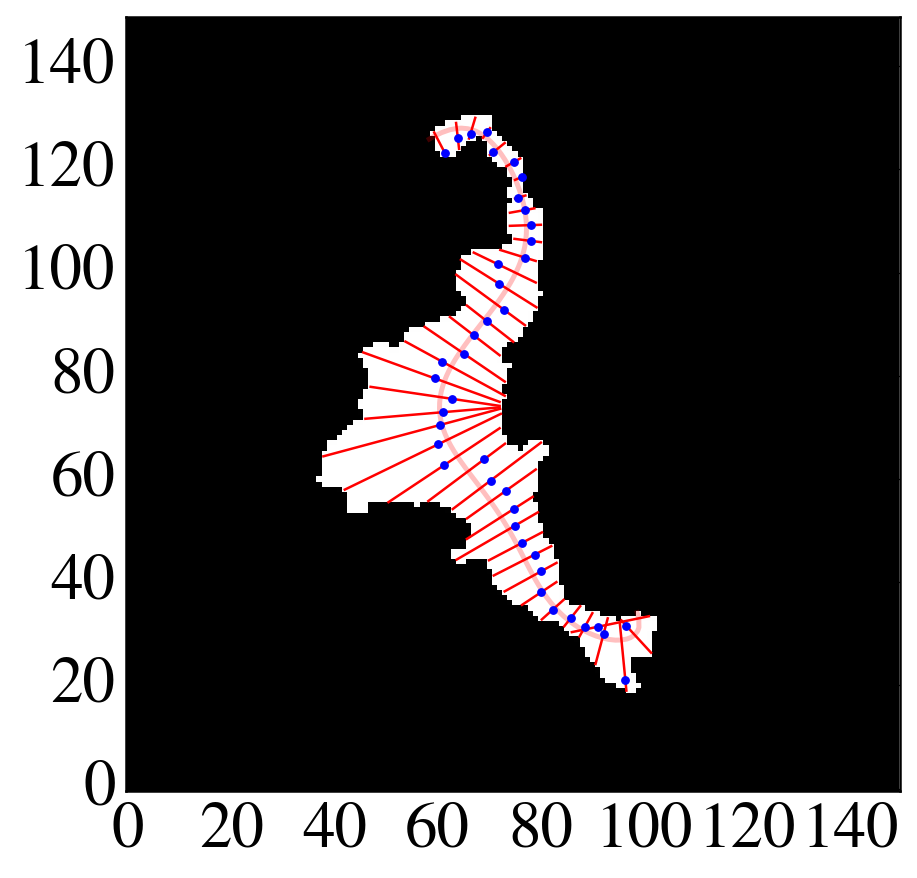

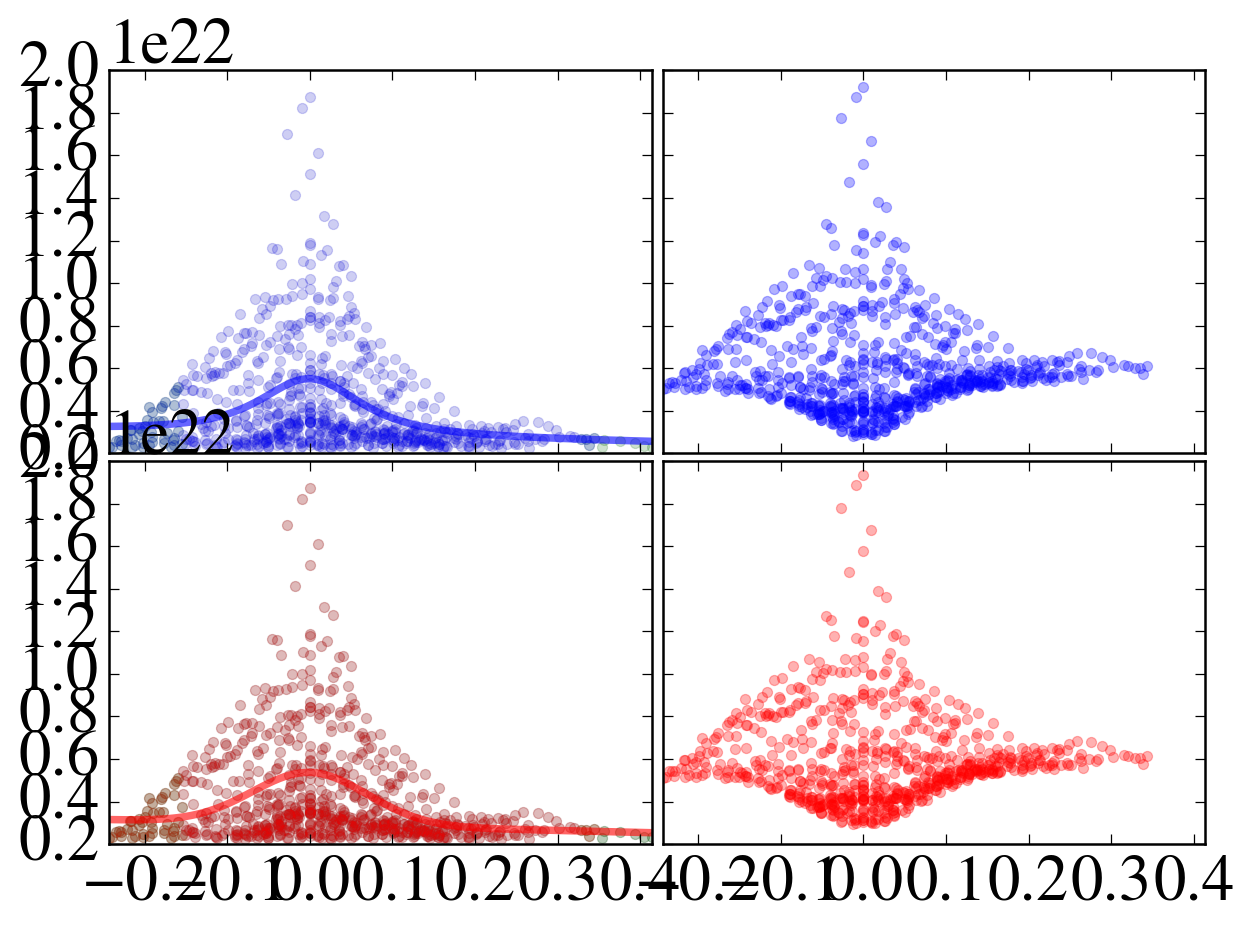

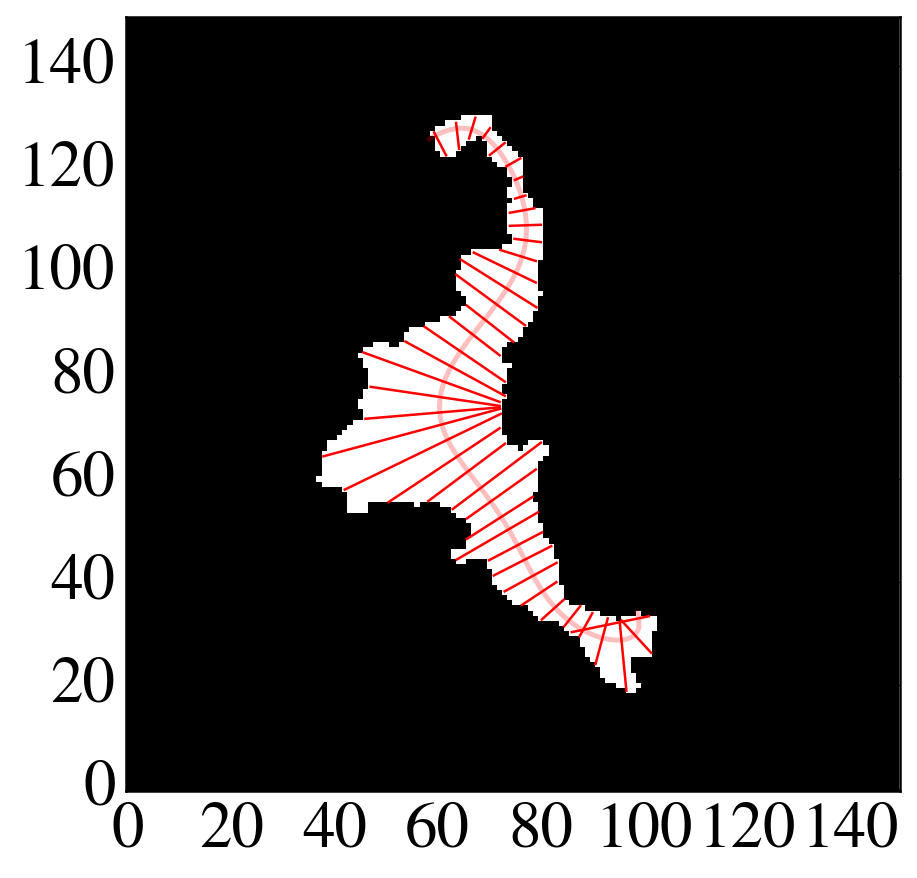

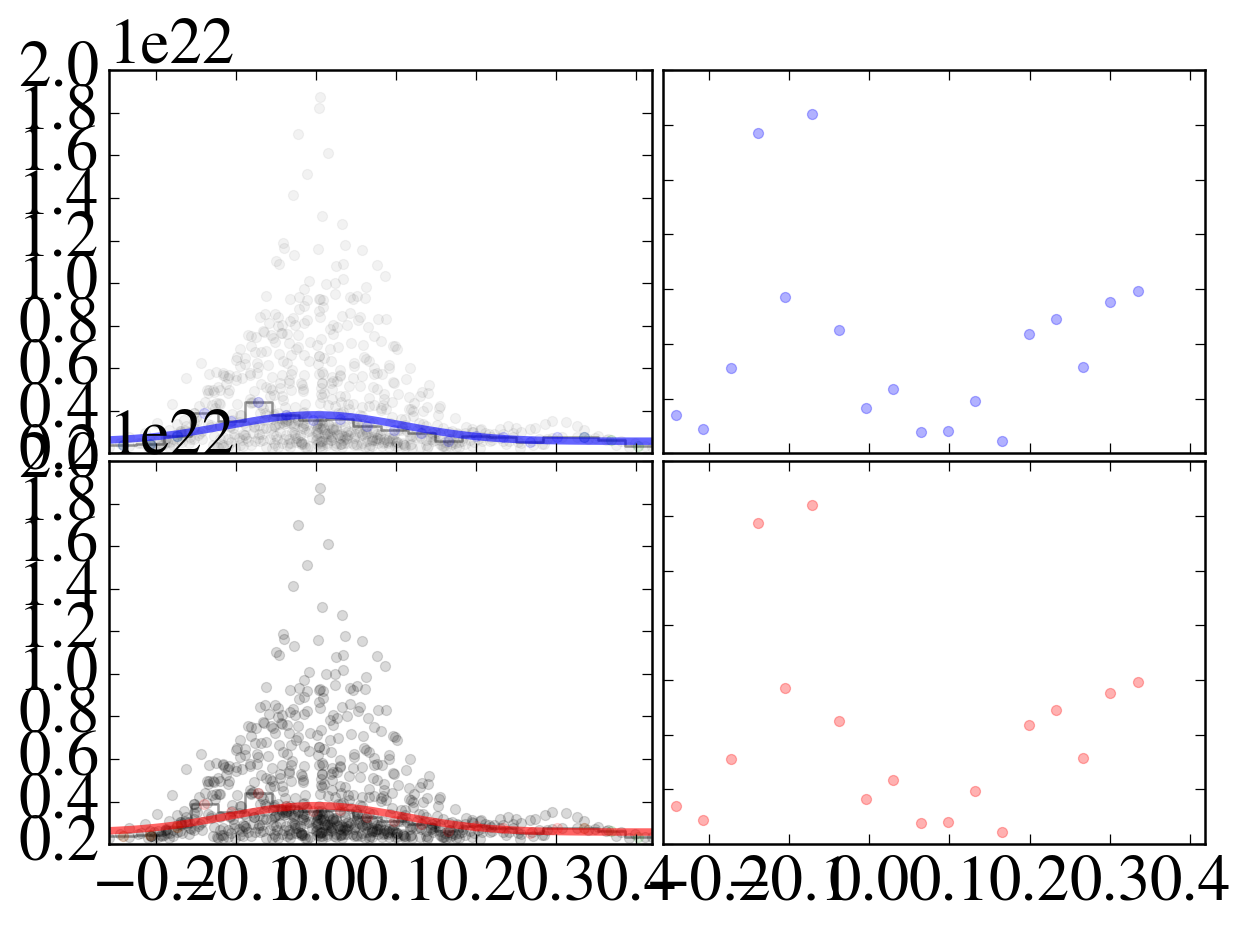

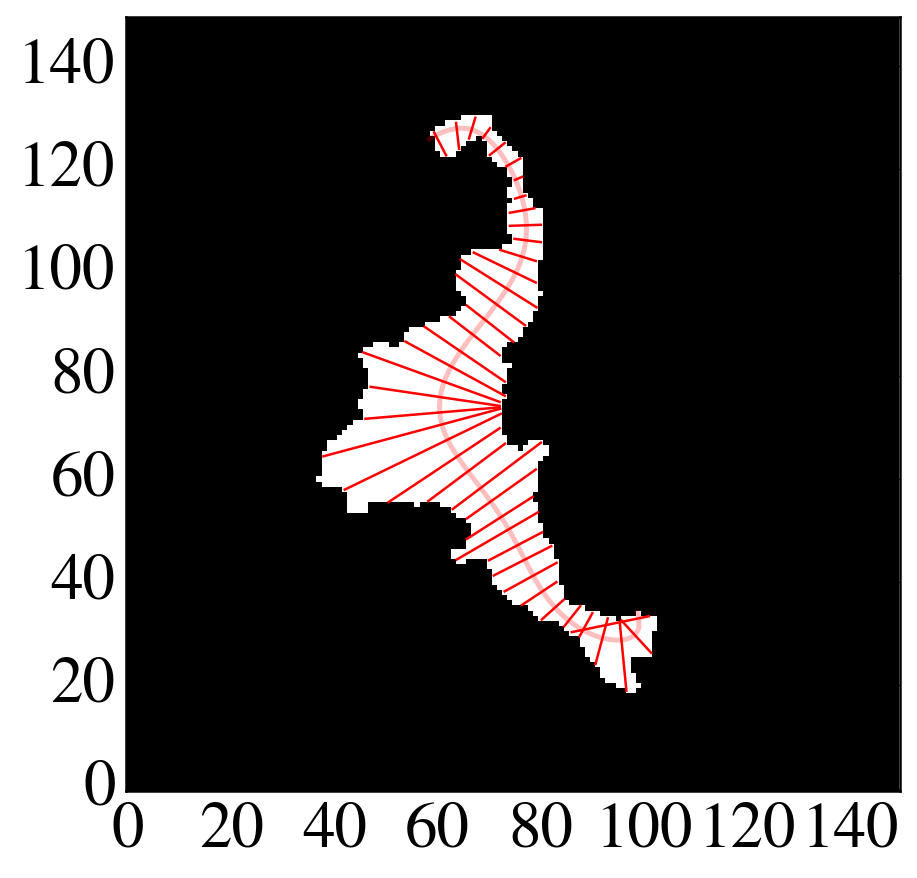

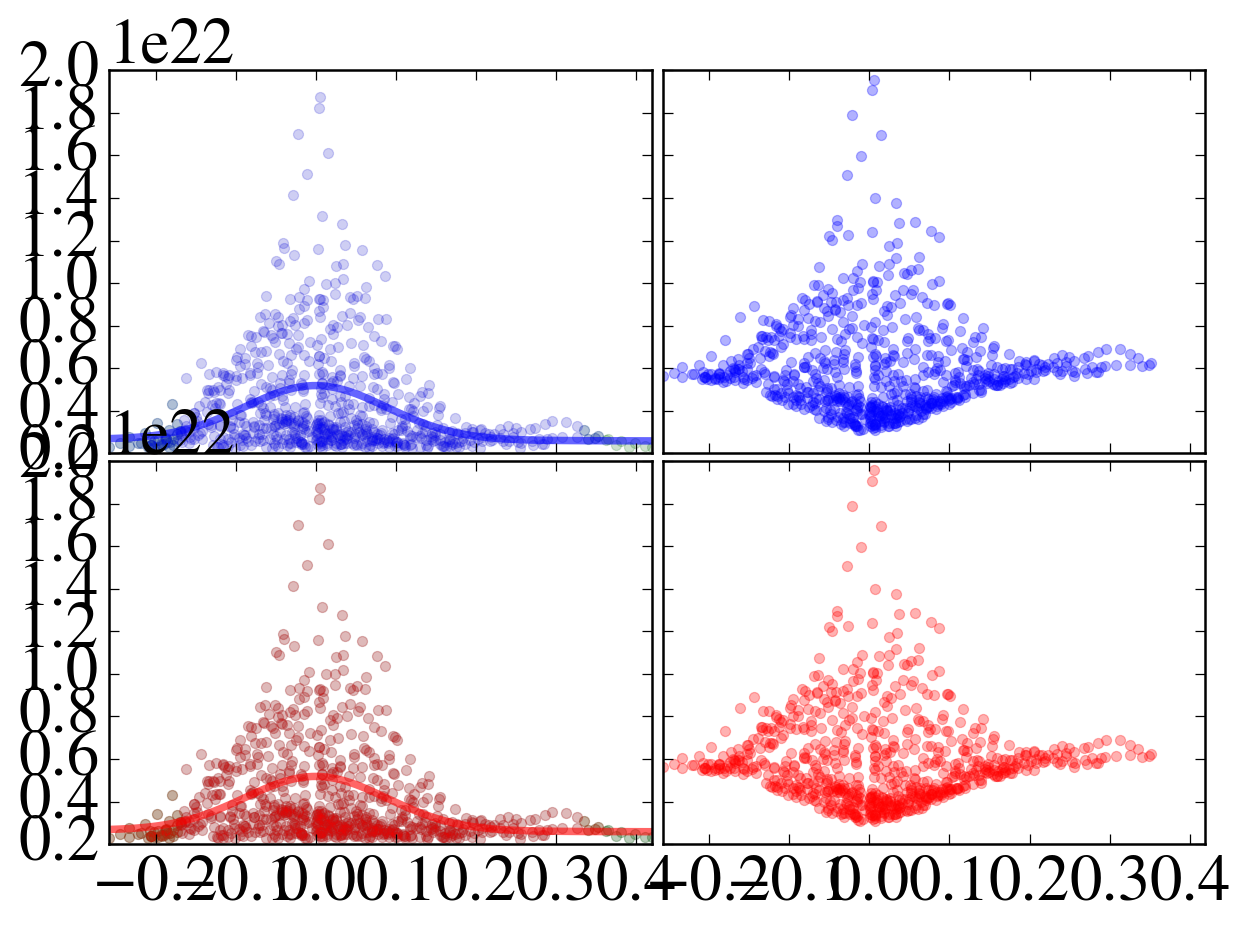

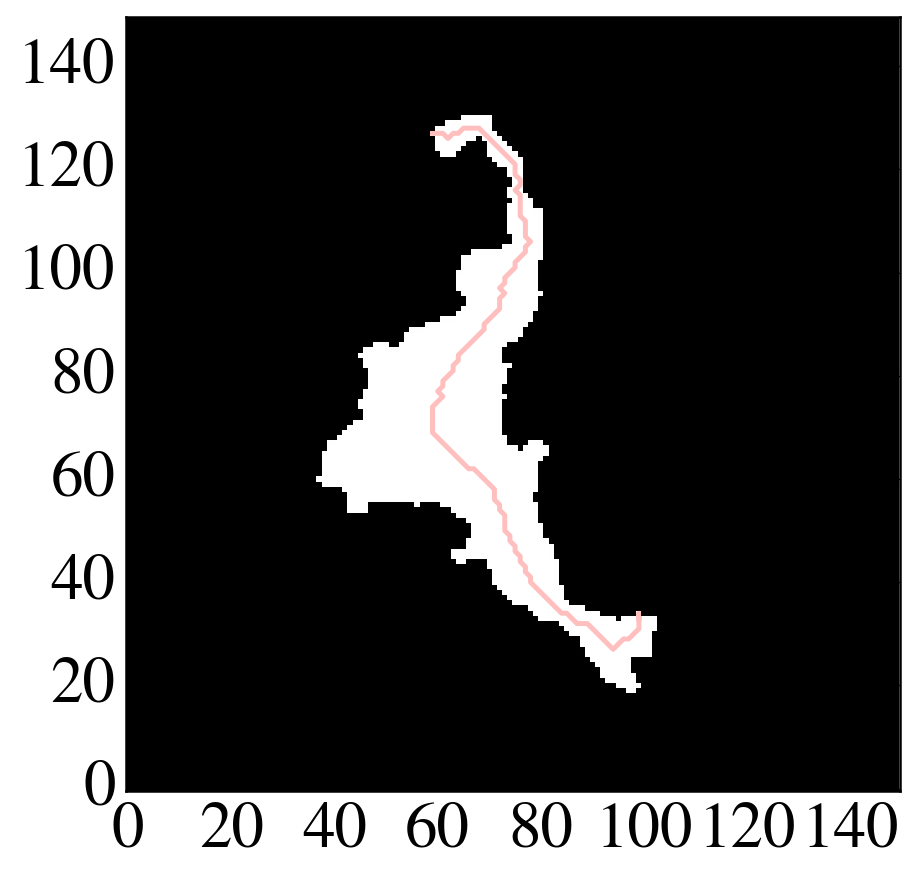

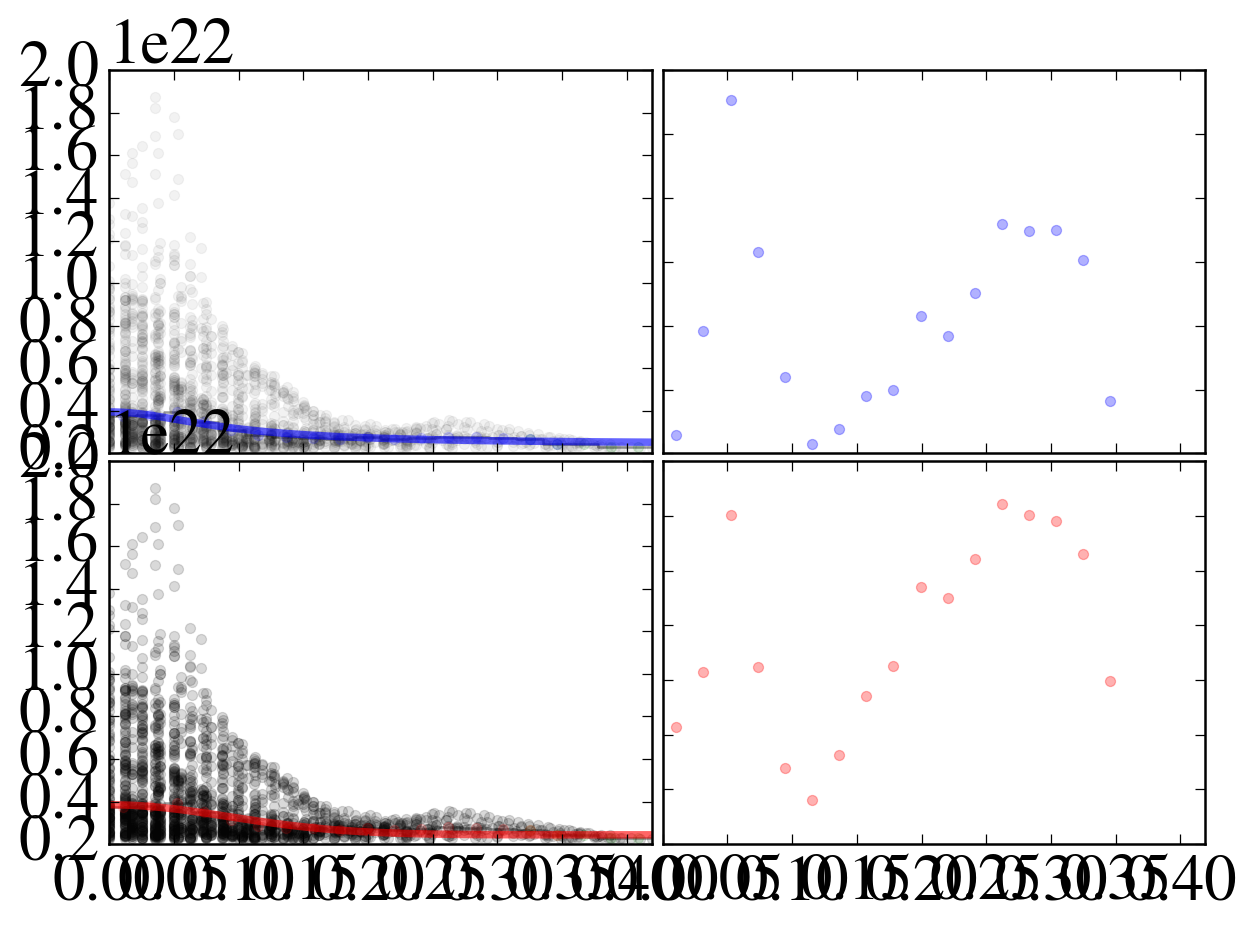

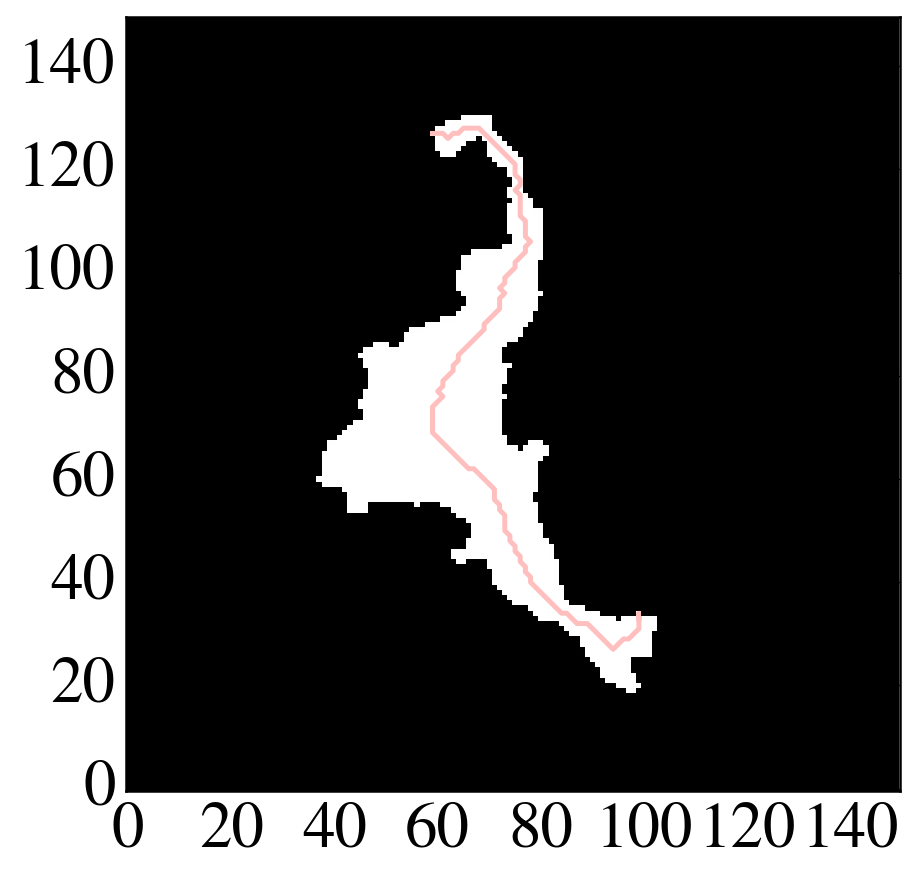

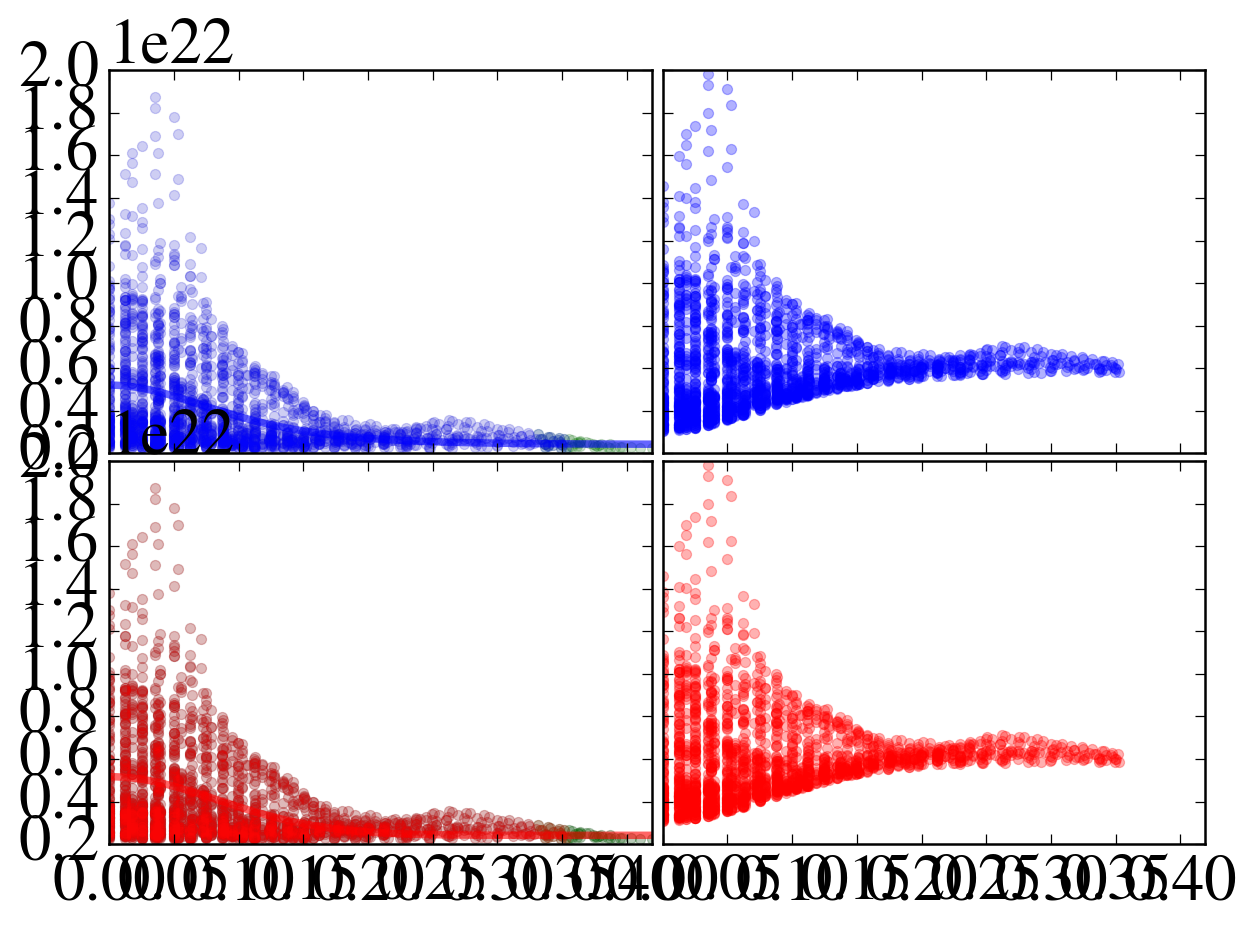

In [6]:
d_tests, d_times = {}, {}
#for cloud in ['PerB5', 'Musca', 'ENZO']:
for cloud in ['PerB5']:
    print cloud, '===='
    d_times_cloud = {}
    
    # Load.
    t0 = time.time()
    radfil = radfil_class.radfil(d_data[cloud]['image'],\
                                 d_data[cloud]['mask'],\
                                 header = d_data[cloud]['header'],\
                                 distance = d_distance[cloud])
    d_times_cloud['loadData'] = time.time() - t0
    
    
    # Make spine
    t0 = time.time()
    radfil.make_fil_spine(beamwidth = d_beamwidths[cloud])
    d_times_cloud['makeSpine'] = time.time() - t0
    
    
    # Go through the setups.
    d_times_buildProfile, d_times_fitProfile = {}, {}
    d_tests_cloud = {}
    for setup in setups:
        print setup, '...'
        ## Extract the profile.
        t0 = time.time()
        radfil.build_profile(samp_int = d_samp_ints[cloud],\
                             bins = (20 if setup[3] == 'o' else None),\
                             shift = (True if setup[2] == 'o' else False),\
                             wrap = (True if setup[1] == 'o' else False),\
                             cut = (True if setup[0] == 'o' else False))
        d_times_buildProfile[setup] = time.time() - t0
        
        ## Attempt fitting.
        t0 = time.time()
        factor = (abs(radfil.header['CDELT1'])*3600.*d_distance[cloud]*u.AU).to(u.pc).value\
                 if (radfil.header is not None) else 1.
        radfil.fit_profile(bgdist = 5*factor, fitdist = 20*factor)
        d_times_fitProfile[setup] = time.time() - t0
        
        ## Return the result.
        d_tests_cloud[setup] = radfil
    ## Return the times.
    d_times_cloud['buildProfile'] = d_times_buildProfile
    d_times_cloud['fitProfile'] = d_times_fitProfile
    d_times[cloud] = d_times_cloud
    
    ## Return the results.
    d_tests[cloud] = d_tests_cloud

In [7]:
d_times['PerB5']

{'buildProfile': {'oooo': 0.2744150161743164,
  'ooox': 0.20566606521606445,
  'ooxo': 0.21236014366149902,
  'ooxx': 0.20055007934570312,
  'oxoo': 0.20425701141357422,
  'oxox': 0.20700788497924805,
  'oxxo': 0.20495080947875977,
  'oxxx': 0.19833588600158691,
  'xoxo': 0.269711971282959,
  'xoxx': 0.2619340419769287},
 'fitProfile': {'oooo': 0.1920919418334961,
  'ooox': 0.19826602935791016,
  'ooxo': 0.2964639663696289,
  'ooxx': 0.2967798709869385,
  'oxoo': 0.21221613883972168,
  'oxox': 0.33481383323669434,
  'oxxo': 0.20673894882202148,
  'oxxx': 0.23152613639831543,
  'xoxo': 0.19856977462768555,
  'xoxx': 0.20259404182434082},
 'loadData': 0.0001900196075439453,
 'makeSpine': 13.85292100906372}

In [8]:
d_times['Musca']

{'buildProfile': {'oooo': 40.57216000556946,
  'ooox': 39.6256308555603,
  'ooxo': 38.88403010368347,
  'ooxx': 40.18656015396118,
  'oxoo': 40.28387403488159,
  'oxox': 41.28968811035156,
  'oxxo': 39.68859505653381,
  'oxxx': 37.09863209724426,
  'xoxo': 68.86196708679199,
  'xoxx': 72.87927007675171},
 'fitProfile': {'oooo': 0.38942813873291016,
  'ooox': 0.22096514701843262,
  'ooxo': 0.43457698822021484,
  'ooxx': 0.24522995948791504,
  'oxoo': 0.2214338779449463,
  'oxox': 0.23502111434936523,
  'oxxo': 0.19608497619628906,
  'oxxx': 0.48795294761657715,
  'xoxo': 0.1945970058441162,
  'xoxx': 0.7807271480560303},
 'loadData': 0.022603988647460938,
 'makeSpine': 2201.5316281318665}

In [9]:
d_times['ENZO']

{'buildProfile': {'oooo': 1.015671968460083,
  'ooox': 1.3347251415252686,
  'ooxo': 1.0253260135650635,
  'ooxx': 1.042937994003296,
  'oxoo': 1.0208380222320557,
  'oxox': 1.4515321254730225,
  'oxxo': 1.0346930027008057,
  'oxxx': 1.0358450412750244,
  'xoxo': 0.7693209648132324,
  'xoxx': 0.7486319541931152},
 'fitProfile': {'oooo': 0.21917390823364258,
  'ooox': 0.2355349063873291,
  'ooxo': 0.19747304916381836,
  'ooxx': 0.23131799697875977,
  'oxoo': 0.2108619213104248,
  'oxox': 0.2530341148376465,
  'oxxo': 0.21263694763183594,
  'oxxx': 0.2749600410461426,
  'xoxo': 0.19897198677062988,
  'xoxx': 0.25626087188720703},
 'loadData': 0.0005831718444824219,
 'makeSpine': 21.616570949554443}

In [39]:
def gaussian(X, amp, cen, sig):
    return amp * np.exp(-(X-cen)**2 /(2.*sig**2.))

def plummer(X,N_0,R_flat,p):
    return (N_0)/(1+(X/R_flat)**2)**((p-1)/2.0)

def inv_plummerlike_func(Y, N_0, p, R_flat):
    return R_flat*np.sqrt(((N_0/Y)**(2./(p-1.))-1.))

In [51]:
(d_data['PerB5']['header']['CDELT2']*3600.*260.*u.AU).to(u.pc)*5/(4.6/512.)

<Quantity 9.821060448014402 pc>

In [52]:
#d_testParams = {}
for cloud in ['ENZO']:
    print cloud, '===='
    
    # Load.
    radfil = d_tests[cloud]['oooo']
    
    
    # Go through the setups.
    d_tests_cloud = {}
    for setup in setups:
        d_tests_setups = {}
        print setup, '...'
        ## Extract the profile.
        radfil.build_profile(samp_int = d_samp_ints[cloud],\
                             bins = (20 if setup[3] == 'o' else None),\
                             shift = (True if setup[2] == 'o' else False),\
                             wrap = (True if setup[1] == 'o' else False),\
                             cut = (True if setup[0] == 'o' else False))
        
        ## Attempt fitting.
        factor = (abs(radfil.header['CDELT1'])*3600.*d_distance[cloud]*u.AU).to(u.pc).value\
                 if (radfil.header is not None) else 1.
        #radfil.fit_profile(bgdist = 5*factor, fitdist = 20*factor)
        radfil.fit_profile(bgdist = 39.3, fitdist = 9.8)
        
        ## Calculate FWHM
        plummer_edge = radfil.profilefit_plummer(np.max(radfil.xfit))
        HM = (radfil.profilefit_plummer.parameters[0]-plummer_edge)/2.+plummer_edge
        FWHM_plummer = 2.*inv_plummerlike_func(HM, *radfil.profilefit_plummer.parameters)
        
        ## Return the result.
        d_tests_setups['width'] = radfil.profilefit_gaussian.parameters[2]
        d_tests_setups['FWHM_Gaussian'] = 2.*np.sqrt(2.*np.log(2.))*radfil.profilefit_gaussian.parameters[2]
        d_tests_setups['R_flat'] = radfil.profilefit_plummer.parameters[2]
        d_tests_setups['p'] = radfil.profilefit_plummer.parameters[1]
        d_tests_setups['FWHM_plummer'] = FWHM_plummer
        
        ## Return it back to one-level up.
        d_tests_cloud[setup] = d_tests_setups
    
    ## Return the results.
    d_testParams[cloud] = d_tests_cloud

ENZO ====
oooo ...
==== Gaussian ====
amplitude: 7.075E+02
width: 2.448
==== Plummer-like ====
amplitude: 8.867E+02
p: 2.432
R_flat: 1.459
ooox ...
No binning is applied.
==== Gaussian ====
amplitude: 3.919E+03
width: 0.415
==== Plummer-like ====
amplitude: 4.018E+03
p: 1.912
R_flat: 0.147
ooxo ...
==== Gaussian ====
amplitude: 4.705E+02
width: 5.704
==== Plummer-like ====
amplitude: 4.965E+02
p: 2.706
R_flat: 5.534
ooxx ...
No binning is applied.
==== Gaussian ====
amplitude: 6.578E+02
width: 15.520
==== Plummer-like ====
amplitude: 6.214E+02
p: 1.000
R_flat: 0.393
oxoo ...
==== Gaussian ====
amplitude: 6.120E+02
width: 2.044
==== Plummer-like ====
amplitude: 6.480E+02
p: 3.892
R_flat: 2.584
oxox ...
No binning is applied.
==== Gaussian ====
amplitude: 3.694E+03
width: 0.326
==== Plummer-like ====
amplitude: 3.711E+03
p: 2.890
R_flat: 0.280
oxxo ...
==== Gaussian ====
amplitude: 3.404E+02
width: 3.782
==== Plummer-like ====
amplitude: 3.422E+02
p: 27.746
R_flat: 19.084
oxxx ...
No bin

samp_int is not used. cut is False.
shift and/or wrap are not used. cut is False.
samp_int is not used. cut is False.


 ...
No binning is applied.
==== Gaussian ====
amplitude: 8.014E+02
width: 10.720
==== Plummer-like ====
amplitude: 8.014E+02
p: 983.442
R_flat: 336.303


shift and/or wrap are not used. cut is False.


In [53]:
for cloud in ['ENZO']:
    print cloud, '===='
    for setup in setups:
        print setup, '------'
        print 'Gaussian:', d_testParams[cloud][setup]['FWHM_Gaussian']
        print 'Plummer:', d_testParams[cloud][setup]['FWHM_plummer']
        print 'p =', d_testParams[cloud][setup]['p']

ENZO ====
oooo ------
Gaussian: 5.76486908386
Plummer: 3.42994760037
p = 2.43174377394
ooox ------
Gaussian: 0.977071432291
Plummer: 0.540226383511
p = 1.91238031922
ooxo ------
Gaussian: 13.4326417857
Plummer: 8.38864030792
p = 2.70642338004
ooxx ------
Gaussian: 36.546086549
Plummer: 0.0
p = 1.0
oxoo ------
Gaussian: 4.81269681898
Plummer: 3.98161390228
p = 3.89196631713
oxox ------
Gaussian: 0.766714993737
Plummer: 0.581922166398
p = 2.88995773611
oxxo ------
Gaussian: 8.90491818529
Plummer: 7.74831243112
p = 27.7456253844
oxxx ------
Gaussian: 17.8789555277
Plummer: 12.3840541217
p = 637.341446786
xoxo ------
Gaussian: 15.1076118182
Plummer: 6.25287290039
p = 1.62414599053
xoxx ------
Gaussian: 25.2447873682
Plummer: 12.7472376504
p = 983.441654141


In [28]:
(abs(d_data['Musca']['header']['CDELT1'])*3600.*d_distance['Musca']*u.AU).to(u.pc).value*5

0.019392545305278654

In [36]:
radfil = d_tests['Musca']['oooo']
t0 = time.time()
radfil.build_profile(samp_int = 20,\
                             bins = 20,\
                             shift = True,\
                             wrap = False,\
                             cut = True)
print time.time()-t0

41.5316691399


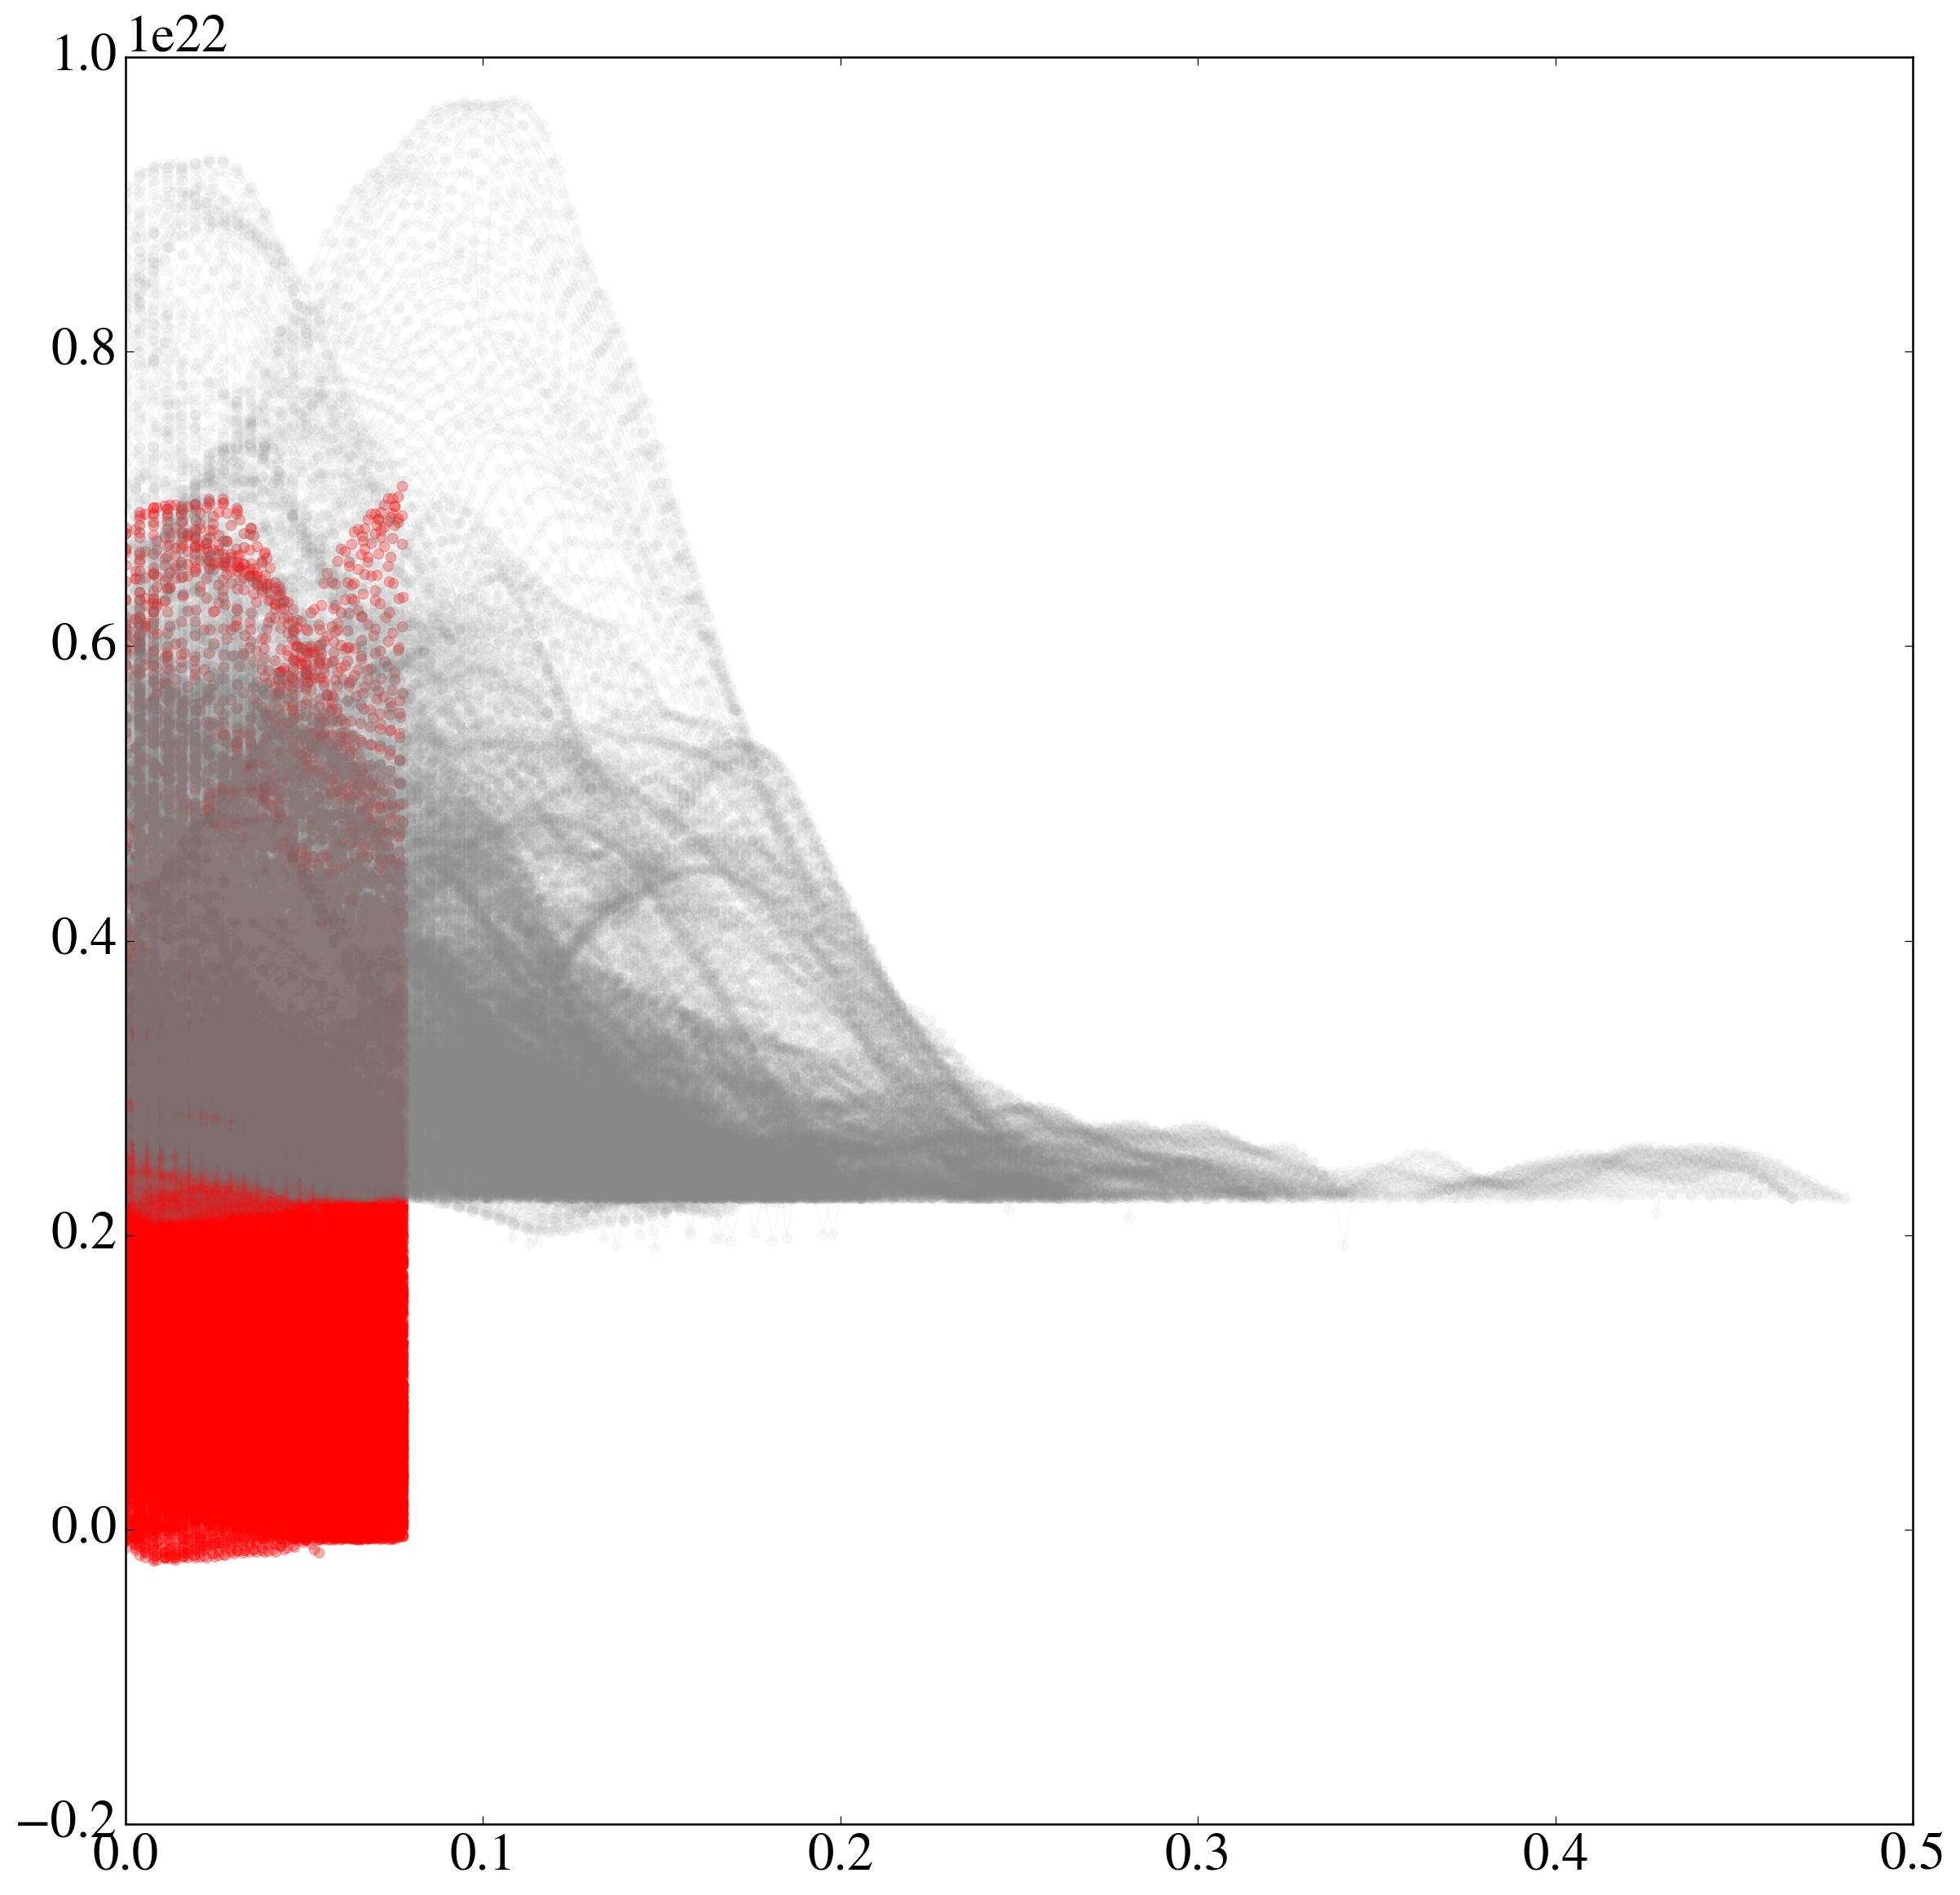

In [33]:
plt.plot(d_tests['Musca']['oooo'].xfit, d_tests['Musca']['oooo'].yfit, 'r.', markersize = 10., alpha = .3)
plt.plot(d_tests['Musca']['oooo'].masterx, d_tests['Musca']['oooo'].mastery,\
         marker = '.', color = 'gray', markersize = 10., alpha = .05)